<a href="https://www.kaggle.com/code/bradhammond/hubmap-exploratory-data-analysis?scriptVersionId=106842104" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Notebook Setup**

In [1]:
# Import statements
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns
import tifffile
import cv2
import tensorflow as tf
from keras import backend as K
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Lambda
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
# Create directories to call in functions

BASE_DIR = "../input/hubmap-organ-segmentation"
TRAIN_DIR = "../input/hubmap-organ-segmentation/train_images"
TEST_DIR = "../input/hubmap-organ-segmentation/test_images"
LABEL_DIR = "../input/hubmap-organ-segmentation/train_annotations"

train_dir = os.listdir(TRAIN_DIR)
test_dir = os.listdir(TEST_DIR)

In [3]:
# Import train and test csv files into data frames

train_path = "../input/hubmap-organ-segmentation/train.csv"
test_path = "../input/hubmap-organ-segmentation/test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [4]:
# Modified from source below these are helpful functions that will help decode and encode RLE
# Credits: https://www.kaggle.com/code/ihelon/hubmap-exploratory-data-analysis

# https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape).T


def read_image(image_id, scale=None, verbose=None):
    image = tifffile.imread(
        os.path.join(BASE_DIR, f"train_images/{image_id}.tiff")
    )
    if len(image.shape) == 5:
        image = image.squeeze().transpose(1, 2, 0)
    
    mask = rle2mask(
        train_df[train_df["id"] == image_id]["rle"].values[0], 
        (image.shape[1], image.shape[0])
    )
    
    if verbose:
        print(f"[{image_id}] Image shape: {image.shape}")
        print(f"[{image_id}] Mask shape: {mask.shape}")
    
    if scale:
        new_size = (256, 256)
        image = cv2.resize(image, new_size)
        mask = cv2.resize(mask, new_size)
        
        if verbose:
            print(f"[{image_id}] Resized Image shape: {image.shape}")
            print(f"[{image_id}] Resized Mask shape: {mask.shape}")
        
    return image, mask


def read_test_image(image_id, scale=None, verbose=None):
    image = tifffile.imread(
        os.path.join(BASE_DIR, f"test_images/{image_id}.tiff")
    )
    if len(image.shape) == 5:
        image = image.squeeze().transpose(1, 2, 0)
    
    if verbose:
        print(f"[{image_id}] Image shape: {image.shape}")
    
    if scale:
        new_size = (256, 256)
        image = cv2.resize(image, new_size)
        
        if verbose:
            print(f"[{image_id}] Resized Image shape: {image.shape}")
        
    return image


def plot_image_and_mask(image, mask, image_id, cmap):
    plt.figure(figsize=(16, 10))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.grid(visible=False)
    plt.title(f"Image {image_id}", fontsize=18)
    
    plt.subplot(1, 3, 2)
    plt.imshow(image)
    plt.grid(visible=False)
    plt.imshow(mask, cmap=cmap, alpha=0.5)
    plt.title(f"Image {image_id} + mask", fontsize=18)    
    
    plt.subplot(1, 3, 3)
    plt.grid(visible=False)
    plt.imshow(mask, cmap=cmap)
    plt.title(f"Mask", fontsize=18)    

    plt.show()
    
    
def plot_grid_image_with_mask(image, mask):
    plt.figure(figsize=(16, 16))
    
    w_len = image.shape[0]
    h_len = image.shape[1]
    
    min_len = min(w_len, h_len)
    w_start = (w_len - min_len) // 2
    h_start = (h_len - min_len) // 2
    
    plt.imshow(image[w_start : w_start + min_len, h_start : h_start + min_len])
    plt.imshow(
        mask[w_start : w_start + min_len, h_start : h_start + min_len], cmap="hot", alpha=0.5,
    )
    plt.axis("off")
            
    plt.show()
    

def plot_slice_image_and_mask(image, mask, start_h, end_h, start_w, end_w, cmap):
    plt.figure(figsize=(16, 5))
    
    sub_image = image[start_h:end_h, start_w:end_w, :]
    sub_mask = mask[start_h:end_h, start_w:end_w]
    
    plt.subplot(1, 3, 1)
    plt.imshow(sub_image)
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(sub_image)
    plt.imshow(sub_mask, cmap=cmap, alpha=0.5)
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(sub_mask, cmap=cmap)
    plt.axis("off")
    
    plt.show()
    
def rle_encode_less_memory(img):
    #the image should be transposed
    pixels = img.T.flatten()
    
    # This simplified method requires first and last pixel to be zero
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)


def to_float(img):
    divided_img = img/255
    float_img = divided_img.astype(dtype = np.float32)
    return float_img

# **Data Preperation**

In [5]:
# Create zeroed np arrays to later store our test and train data.

X_train = np.zeros((len(train_dir), 256, 256, 3), dtype=np.uint8)
Y_train = np.zeros((len(train_dir), 256, 256, 1), dtype=np.uint8)

X_test = np.zeros((len(test_dir), 256, 256, 3), dtype=np.uint8)

In [6]:
# Take train images from dir and import them into np.arrays 

for i, name in enumerate(train_dir):
    s_name = name[slice(-5)]
    s_name = int(s_name)
    image, mask = read_image(s_name, scale = True)
    img_segment_full = np.zeros((256, 256, 1), dtype=np.uint8)
    img_segment = np.expand_dims(mask, axis=-1)
    img_segment_full = np.maximum(img_segment_full, img_segment)
    X_train[i] = image
    Y_train[i] = img_segment_full

In [7]:
# Take test images from dir and import them into np.arrays 
Id_store = []
for i, name in enumerate(test_dir):
# take name of slice from test dir and make it into an array to make submission easier
    s_name = name[slice(-5)]
    s_name = int(s_name)
    Id_store.append(s_name)
# read images from the test dir and store them in our np test array
    image = read_test_image(s_name, scale = True)
    X_test[i] = image

Text(0.5, 1.0, 'Predicted image')

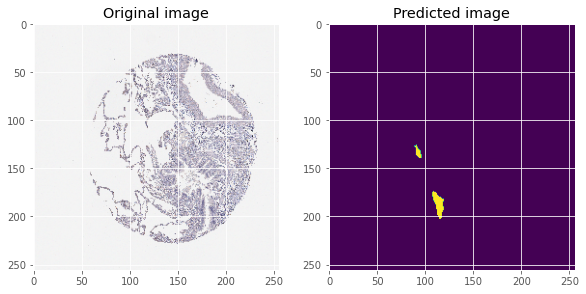

In [8]:
# Check to make sure images are stored properly in arrays
plt.figure(figsize=(15, 32))
plt.subplot(1,3,1)
plt.imshow(X_train[3])
plt.title('Original image')
plt.subplot(1,3,2)
plt.imshow(Y_train[3])
plt.title('Predicted image')

In [9]:
# Convert the training dataset to float32, you have to do this because the loss funtions and metrics will not accept uint8
new_train = np.zeros((len(train_dir), 256, 256, 3), dtype=np.float32)
new_y = np.zeros((len(train_dir), 256, 256, 1), dtype=np.float32)


for i, name in enumerate(X_train):
    new_img = X_train[i]/255
    new_train[i] = new_img
    
for i, name in enumerate(Y_train):
    new_img = Y_train[i]/255
    new_y[i] = new_img    

print(new_y.shape)

(351, 256, 256, 1)


In [26]:
new_test = np.zeros((len(test_dir), 256, 256, 3), dtype=np.float32)

for i, name in enumerate(X_test):
    new_img = X_test[i]/255
    new_test[i] = new_img  

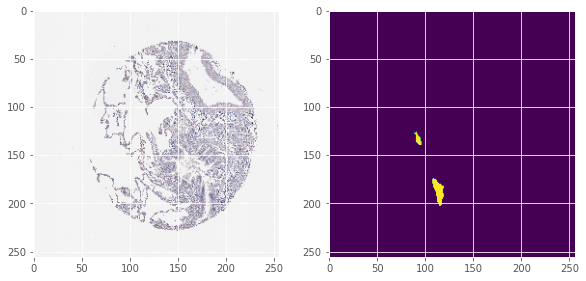

In [29]:
# Confirm conversion to float32 did not degrade images
plt.figure(figsize=(15, 32))
plt.subplot(1,3,1)
plt.imshow(new_train[3])
plt.subplot(1,3,2)
plt.imshow(new_y[3])

In [12]:
# Split training data into training and validation data

train, val, y_train, y_val = train_test_split(new_train, new_y, test_size=0.2)

In [13]:
# Define custom loss functions and metrics taken from notebook linked below
# Credit: https://www.kaggle.com/code/maxitype/6-u-net-custom-iou-beginner

def iou(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    iou = K.mean((intersection + 1) / (union + 1), axis=0)
    return iou

def mean_iou(y_true, y_pred):
    results = []   
    for t in np.arange(0.5, 1, 0.05):
        t_y_pred = tf.cast((y_pred > t), tf.float32)
        pred = iou(y_true, t_y_pred)
        results.append(pred)
        
    return K.mean(K.stack(results), axis=0)


def dice_loss(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + 1) / (union + 1), axis=0)
    return 1. - dice

# **Model Creation**

This is a U-net model by [Ronneberger et al](https://arxiv.org/abs/1505.04597). 

Code was abopted from: https://www.kaggle.com/code/maxitype/6-u-net-custom-iou-beginner

In [14]:
inputs = Input((256, 256, 3))
s = tf.keras.layers.Lambda(lambda x: x/255.0)(inputs)

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = UpSampling2D(size=(2,2))(conv5)
up6 = concatenate([up6, conv4])
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = UpSampling2D(size=(2,2))(conv6)
up7 = concatenate([up7, conv3])
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = UpSampling2D(size=(2,2))(conv7)
up8 = concatenate([up8, conv2])
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = UpSampling2D(size=(2,2))(conv8)
up9 = concatenate([up9, conv1])
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = models.Model(inputs=[inputs], outputs=[conv10])

model.compile(optimizer=optimizers.Adam(learning_rate=2e-4), loss= dice_loss, metrics= mean_iou)
model.summary()

2022-09-29 18:06:33.031019: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

# **Model Training**

In [15]:
history = model.fit(x= train, y = y_train,
                    steps_per_epoch=len(train)/8,
                    validation_data= (val, y_val),
                    validation_steps=len(val)/8,
                    epochs=5
                   )

2022-09-29 18:06:41.134591: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
35/35 [==============================] - 297s 8s/step - loss: 0.9992 - mean_iou: 0.1043 - val_loss: 0.9990 - val_mean_iou: 0.1043
Epoch 2/5
35/35 [==============================] - 296s 8s/step - loss: 0.9453 - mean_iou: 0.1045 - val_loss: 0.8956 - val_mean_iou: 0.1043
Epoch 3/5
35/35 [==============================] - 292s 8s/step - loss: 0.8955 - mean_iou: 0.1045 - val_loss: 0.8956 - val_mean_iou: 0.1043
Epoch 4/5
35/35 [==============================] - 298s 9s/step - loss: 0.8955 - mean_iou: 0.1045 - val_loss: 0.8956 - val_mean_iou: 0.1043
Epoch 5/5
35/35 [==============================] - 292s 8s/step - loss: 0.8955 - mean_iou: 0.1045 - val_loss: 0.8956 - val_mean_iou: 0.1043


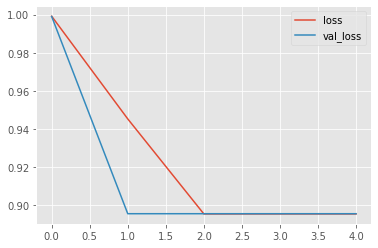

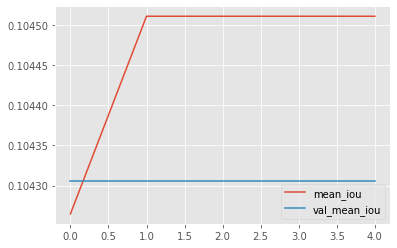

In [16]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['mean_iou', 'val_mean_iou']].plot();

# **Model Prediction and Data Preperation for Submission**

In [30]:
test_predict = model.predict(new_test, verbose =1)

1/1 [==============================] - 0s 443ms/step


Text(0.5, 1.0, 'Predicted image')

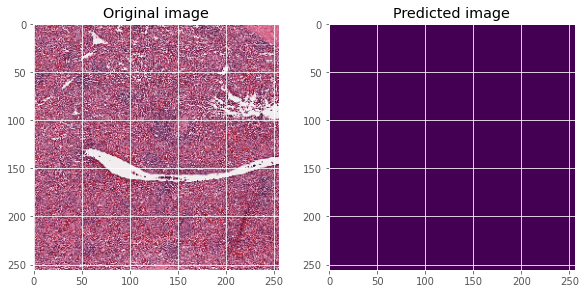

In [31]:
plt.figure(figsize=(15, 32))
plt.subplot(1,3,1)
plt.imshow(new_test[0])
plt.title('Original image')
plt.subplot(1,3,2)
plt.imshow(np.squeeze(test_predict[0]))
plt.title('Predicted image')

In [32]:
# threshold the value of the prediction pixel to reduce noise in the predicted image. 
pred_rle = []
for i in range(len(test_predict)):
    squeeze_img = test_predict[i]
    threshold = 0.5
    threshold_img = np.where(squeeze_img < threshold, 0, 1)
    pred_rle.append(rle_encode_less_memory(threshold_img))

Text(0.5, 1.0, 'Predicted image')

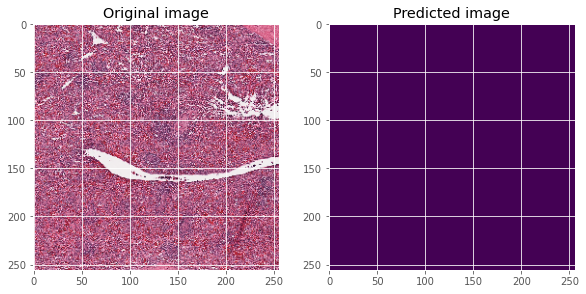

In [33]:
# visualize the results of my model
plt.figure(figsize=(15, 32))
plt.subplot(1,3,1)
plt.imshow(X_test[0])
plt.title('Original image')
plt.subplot(1,3,2)
plt.imshow(threshold_img)
plt.title('Predicted image')

There are clearly some issues with this model, as there are no predicted pixels. 

Areas of improvement: 
1. Build a simple model from scratch in order to quickly iterate what works and what doesn't. 
2. Try a different prebuilt model that will better adapt to the segmentation in these images.
3. I'll want to check the sucessful submission for potential pitfalls that I missed when creating this submission. 
4. I need to figure out why I have zero predictided pixels when I switch my loss function from binary cross entropy to dice loss. Also, this likely contributes to my loss function plateauing. 

In [36]:
# Store data in a df and convert the df to a csv file for submission
df = pd.DataFrame({'id':Id_store,'rle':pred_rle})
df.to_csv('submission.csv',index=False)